In [1]:
import torch
import torch.nn as nn
import time 
from time import sleep
import datetime
import os 
import cv2
import glob 
import numpy as np 
import torch.optim as optim
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader 
from sklearn.model_selection import train_test_split
import pandas as pd
import TrainHelper as th
import CustomModels as cm

import CustomImageDataset as cid
import torch.nn.functional as F
import LossFunction as lf 
from torchvision.io import read_image, ImageReadMode
device = ("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.transforms.v2 import GaussianBlur
!pip install torchinfo
from torchinfo import summary

C:\Users\bajajp\AppData\Local\anaconda3\envs\Xmen\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\bajajp\AppData\Local\anaconda3\envs\Xmen\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please

In [2]:
model = torch.jit.load("//cgmqnap.clearguide.local/data/Needles/Lumena/models/hub_regression/model_cyc_1_ep_400_bs_64_lr_0.0001_20231220_T173517.pt")

In [3]:
parent_dir = "C:/Lumena"

train_data_folder = "train_data"

sub_folders = ["SS"]

csv_filename = ["cropped_256x256_original.csv","cropped_256x256.csv"]
img_dir = ["images_cropped_256x256_original","images_cropped_256x256"]
mask_dir = ["masksLined_cropped_256x256_original","masksLined_cropped_256x256"]

# sub_folders = ["SS"]
# csv_filename = ["cropped_256x256_original.csv"]
# img_dir = ["images_cropped_256x256_original"]
# mask_dir = ["masks_cropped_256x256_original"]

In [4]:
FullRange = False 
Gray = False
ifTrain = False 
ifMSKCha = True 

images_path = []
labels = []

for k in range(len(csv_filename)):
    dfs = []
    for ele in sub_folders:
        df = pd.read_csv(parent_dir + "/" + train_data_folder + "/" + ele +"/" + csv_filename[k])
        dfs.append(df)

    for i in range(len(dfs)): 
        for name in zip(dfs[i]["Images"], dfs[i]["Hub Y"], dfs[i]["Hub X"], dfs[i]["Hub Present"]): 
            if name[3]:
                label_ele = [] 
                images_path.append(parent_dir + "/" + train_data_folder + "/" + sub_folders[i] + "/" + img_dir[k] + "/" + name[0])
                label_ele.append(parent_dir + "/" + train_data_folder + "/" + sub_folders[i] + "/" + mask_dir[k] + "/" + name[0])
                label_ele.append(name[1:])
                labels.append(label_ele)
      
    
X_train, X_val, y_train, y_val = train_test_split(images_path, labels, test_size = 0.2, random_state = 24)

train_dataset = cid.Custom_ImageRegressor_Dataset(X_train, y_train, ifgray = Gray, ifTrain = ifTrain, ifFullRange = FullRange, ifAddMskCha = ifMSKCha)
val_dataset = cid.Custom_ImageRegressor_Dataset(X_val, y_val, ifgray = Gray, ifTrain = ifTrain, ifFullRange = FullRange, ifAddMskCha = ifMSKCha)

In [5]:
image_itr = iter(train_dataset)

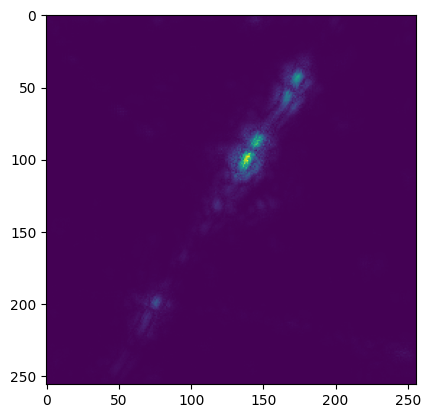

In [27]:
data = next(image_itr)

img = data[0]
cha_, height_, width_  = img.size()
image_gpu = img.to(device)
image_gpu.requires_grad = True 

pred_yx = model(torch.reshape(image_gpu,(1,cha_,height_,width_)))

scores = pred_yx[0][0]
scores.backward()
saliency, _ = torch.max(image_gpu.grad.data.abs(), dim = 0)

sal = saliency.detach().cpu().numpy()
plt.imshow(sal)

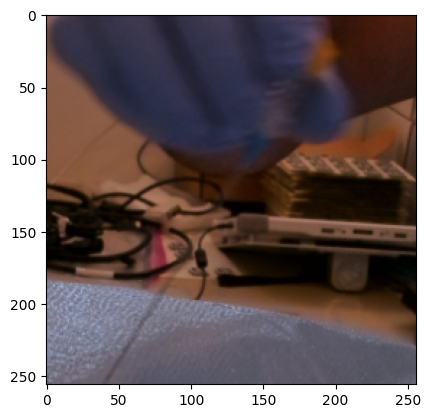

In [28]:
img_numpy = np.transpose(img, (1,2,0))[:, :, 0:3]
plt.imshow(img_numpy)